In [1]:
%load_ext autoreload
%autoreload 2

In [123]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import peakutils as pk
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from tqdm.notebook import trange, tqdm

from scipy.spatial import distance

from dechorate import constants
from dechorate.dataset import DechorateDataset, SyntheticDataset
from dechorate.utils.mds_utils import trilateration
from dechorate.utils.file_utils import save_to_pickle, load_from_pickle, save_to_matlab
from dechorate.utils.dsp_utils import normalize, envelope
from dechorate.utils.geo_utils import plane_from_points, mesh_from_plane, square_within_plane, dist_point_plane

In [3]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [4]:
# which dataset?
dataset_id = '011111'
L = 19556
c = constants['speed_of_sound']
Fs = constants['Fs']
recording_offset = constants['recording_offset']

# which source?
srcs_idxs = [0]
J = len(srcs_idxs)

# which microphonese?
# mics_idxs = [0, 1, 5, 6, 10, 11, 15, 16, 20, 21, 25]
mics_idxs0 = [0, 5, 10, 15, 20, 25]
mics_idxs1 = [1, 6, 11, 16, 21, 26]
mics_idxs2 = [2, 7, 12, 17, 22, 27]
mics_idxs3 = [3, 8, 13, 18, 23, 28]
mics_idxs4 = [4, 9, 14, 19, 24, 29]
mics_idxs = mics_idxs0 + mics_idxs1

I = len(mics_idxs)
K = 7

In [5]:
dataset_dir = os.path.join('..','data','final')

path_to_dataset_hdf5 = os.path.join(dataset_dir, 'dechorate_with_rirs.hdf5')
path_to_annotation_csv = os.path.join(dataset_dir, 'annatotion.csv')
path_to_mics_srcs_echo_annotation_pkl = os.path.join(dataset_dir, 'mics_srcs_echo_annotation.pkl')
path_to_echo_annotation_pkl = os.path.join(dataset_dir, 'echo_annotation.pkl')

note_dict = load_from_pickle(path_to_mics_srcs_echo_annotation_pkl)
dset = DechorateDataset(path_to_dataset_hdf5, path_to_annotation_csv, path_to_mics_srcs_echo_annotation_pkl)
dset.set_entry('000000', 0, 0)
rir = dset.get_rir()
m, s = dset.get_mic_and_src_pos()
toas = dset.get_echo(kind='pck')

In [136]:
rirs = np.zeros([L, 30, 4])
toas_pck = np.zeros([7,30,4])
toas_sym = np.zeros([7,30,4])

for j in trange(4):
    for i in trange(30):
        dset.set_entry('011111', i, j)
        rir = dset.get_rir().squeeze()
        toas_pck[:,i,j] = np.sort(dset.get_echo(kind='pck'))
        toas_sym[:,i,j] = np.sort(dset.get_echo(kind='sym'))
        rirs[:,i,j] = rir[:L]/np.max(np.abs(rir[:L]))

In [137]:
def plot_rir_skyline(ax, rirs, toas_pck=None, toas_sym=None, echoes_pck=range(7), echoes_sym=range(7)):

    refl_order_calibr = constants['refl_order_calibr'][:7]
    refl_order_pyroom = constants['refl_order_pyroom']
    recording_offset = constants['recording_offset']

    L, I, J = rirs.shape
    rirs_skyline = np.abs(rirs.transpose([0, 2, 1]).reshape([L, I*J]))
    ax.imshow(rirs_skyline, extent=[0, I*J, 0, L], aspect='auto')

    # plot srcs boundaries
    for j in range(J):
        ax.axvline(j*30, color='C7')

    for k in echoes_pck:
        if toas_pck is not None:
            wall = refl_order_calibr[k]
            r = k
            ax.scatter(np.arange(I*J)+0.5, L - toas_pck[r, :, :].T.flatten()*Fs, c='C%d' % (k+2), marker='x', label='%s Picking' % wall)
    
    for k in echoes_sym:
        if toas_sym is not None:
            r = k
            wall = refl_order_calibr[k]
            ax.scatter(np.arange(I*J)+0.5, L - toas_sym[r, :, :].T.flatten()*Fs, marker='o', facecolors='none', edgecolors='C%d' % (k+2), label='%s ISM' % wall)


    ax.set_ylim([18200, L])
    ax.set_xlim([0, I*J])
    ax.legend(bbox_to_anchor=(1,1), loc="upper left")
    return

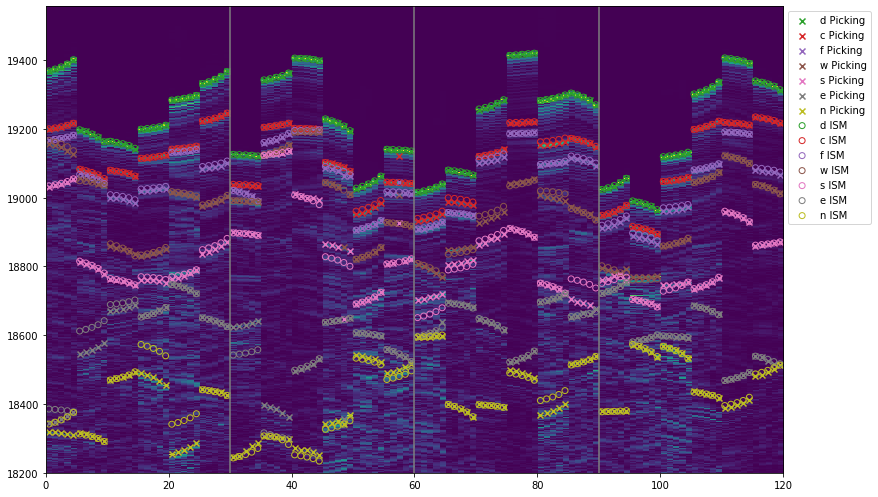

In [138]:
scaling = 0.8
fig = plt.figure(figsize=(16*scaling, 9*scaling))
ax1 = fig.add_subplot(111)
plt.subplots_adjust(left=0.15, bottom=0.05, right=0.95, top=0.95)
plot_rir_skyline(ax1, rirs, 
                 toas_pck=toas_pck, echoes_pck=[0, 1, 2, 3, 4, 5, 6], 
                 toas_sym=toas_sym, echoes_sym=[0, 1, 2, 3, 4, 5, 6])
plt.savefig(os.path.join('skyline.pdf'), dpi=300)

In [ ]:
# make src and mic note
